<a href="https://colab.research.google.com/github/kenzfinn/csc1035_lecture_examples/blob/master/CSC3831_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB channels
])

# Load dataset with transformations
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

Files already downloaded and verified


In [8]:
class CNNWithBN(nn.Module):
    def __init__(self):
        super(CNNWithBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.bn2(self.conv2(x))
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNWithoutBN(CNNWithBN):
    def __init__(self):
        super(CNNWithoutBN, self).__init__()
        #overwrites the batch normalisation in using the superclass
        self.bn1 = nn.Identity()
        self.bn2 = nn.Identity()

In [24]:
def train_model(model, train_loader, val_loader, epochs=5, patience=5):
    training_log = []
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        print(f"Epoch {epoch+1} : Train Loss={train_loss/len(train_loader)}, Val Loss={val_loss/len(val_loader)}")
        epoch_data = {
        "epoch": epoch,
        "training_loss": train_loss/len(train_loader),
        "validation_loss": val_loss/len(val_loader)
        }
        training_log.append(epoch_data)

        # early stopping occurs when validation loss doesn't change after a certain patience (numer of epochs)
        if val_loss < best_loss:
            best_loss = val_loss
            #initialised as infinity so first val_loss always 'best loss'
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Save the best model
    torch.save(best_model, 'best_model.pth')
    return best_model, training_log


In [ ]:
# Visualization of Features
def visualize_filters_and_features(model, test_image):
    # Visualize Filters
    for name, param in model.named_parameters():
        if "weight" in name and len(param.size()) == 4:  # Convolutional filters
            filters = param.detach().cpu()
            fig, axes = plt.subplots(1, min(8, filters.size(0)))
            for i, ax in enumerate(axes):
                ax.imshow(filters[i, 0, :, :], cmap='gray')
                ax.axis('off')
            plt.show()

    # Visualize Feature Maps
    hooks = []
    feature_maps = []

    def hook_fn(module, input, output):
        feature_maps.append(output.detach().cpu())

    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    model.eval()
    with torch.no_grad():
        _ = model(test_image.unsqueeze(0))  # Forward pass with test image

    for fmap in feature_maps:
        fig, axes = plt.subplots(1, min(8, fmap.size(1)))
        for i, ax in enumerate(axes):
            ax.imshow(fmap[0, i, :, :], cmap='gray')
            ax.axis('off')
        plt.show()

    for hook in hooks:
        hook.remove()


In [23]:
model_with_bn = CNNWithBN()
model_without_bn = CNNWithoutBN()

# Train models
bn_training_log = []
non_bn_training_log = []
best_model_bn, bn_training_log = train_model(model_with_bn, train_loader, val_loader)
best_model_wo_bn, no_bn_training_log = train_model(model_without_bn, train_loader, val_loader)

# Visualize
test_image, _ = dataset[0]  # Get a sample test image
visualize_filters_and_features(model_with_bn, test_image)
visualize_filters_and_features(model_without_bn, test_image)

AttributeError: 'CNNWithBN' object has no attribute 'name'

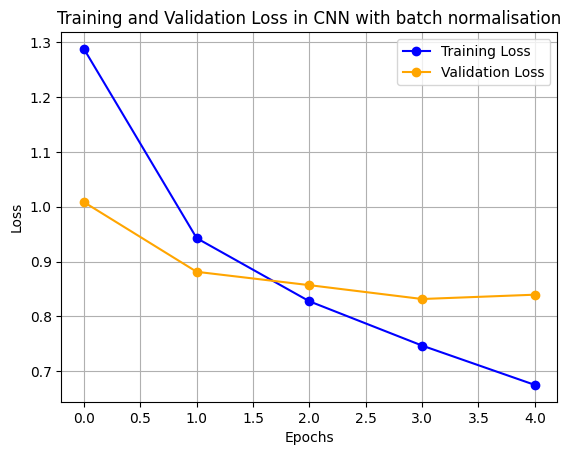

In [17]:

epochs = [entry["epoch"] for entry in bn_training_log]
training_losses = [entry["training_loss"] for entry in bn_training_log]
validation_losses = [entry["validation_loss"] for entry in bn_training_log]

# Plot the losses
plt.plot(epochs, training_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_losses, label="Validation Loss", marker='o', color='orange')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss in CNN with batch normalisation")
plt.legend()
plt.grid(True)
plt.show()

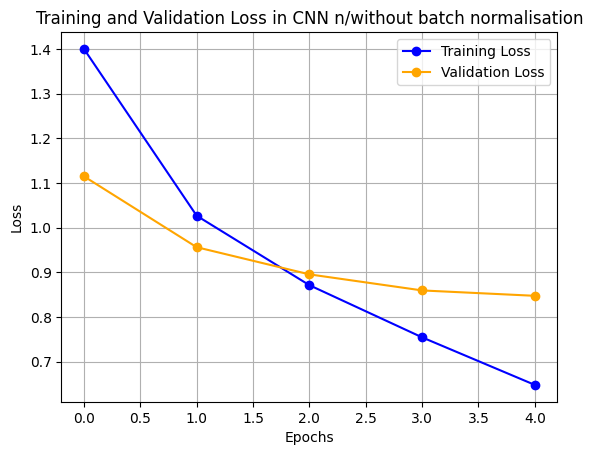

In [21]:
epochs = [entry["epoch"] for entry in no_bn_training_log]
training_losses = [entry["training_loss"] for entry in no_bn_training_log]
validation_losses = [entry["validation_loss"] for entry in no_bn_training_log]

# Plot the losses
plt.plot(epochs, training_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_losses, label="Validation Loss", marker='o', color='orange')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss in CNN without batch normalisation")
plt.legend()
plt.grid(True)
plt.show()